In [1]:
#import sys
#sys.path.append('C:\\Users\\mabdalla\\OneDrive - ec-lyon.fr\\Documents\\Python Scripts\\packages')
import torch
import numpy as np
import photontorch as pt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from photontorch.environment import current_environment
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import butter#, lfilter
import pandas as pd 
from photontorch import BoundedParameter
from ipywidgets import interact
from tqdm.notebook import trange
torch.__version__

'1.6.0'

### Components: PD, MZ Intensity Modulator, Electronic combiner, Optical Attenuator, Readout, CW Laser

In [2]:
class attenuator(pt.Component):
    """
    The optical attenuator is a 2 port component that attenuates the signal. It is bounded from 0 to 1.
    The attenuation is trainable.
    
    Terms: 
    Optical  0 ----- 1  Optical
            
    """      
    num_ports = 2
    
    def __init__(
    self,
    trainable = True,
    attenuation = 0.0,
    name=None,
    ): 
        #self.attenuation = float(attenuation)
        super(attenuator, self).__init__(name=name)
        if trainable:
            self.attenuation = BoundedParameter(
            data=torch.tensor(attenuation, device=self.device),
            bounds=(0.0, 1.0),
            requires_grad=True,
            )
        else:
            self.attenuation = pt.Buffer(
            data=torch.tensor(attenuation, device=self.device), requires_grad=False
            )
    
    def set_S(self, S):
        S[0,:,0,1] = S[0,:,1,0] = (1.0-self.attenuation) ** 0.5

        return S

In [3]:
class cw_laser(pt.Component):
    """
    A CW Laser used when multiple sources are desired in a network. Note: When linking, terminate the component's 
    0 port.

    Terms: 
        0 ---- 1 
    
    """    
    num_ports = 2
    
    def __init__(
        self,
        Power = 1,  #Input the laser power here
        delay=0,
        name = None,  
        ):
        
        super(cw_laser,self).__init__(name=name) 
        self.Power = float(Power)
        self.delay = float(delay)
            
    def action(self, t, x_in, x_out):
        #Input port actions
        a_in, _ = x_in
        x_out[0] = a_in  #Nothing happens to input node
        
        if t<self.delay:
            x_out[1,0] = 0.0001  #Zero noise floor
        else:
            x_out[1,0] = self.Power ** 0.5
        
        x_out[1,1] = 0  #no phase information, this is a real source
        
        #print(x_out[1,0])  #for debugging
        
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

In [4]:
class mask(pt.Component):
    """
    A masking signal that is either binary or from a standard distribution.

    Terms: 
        0 ---- 1 
    
    """       
    num_ports = 2
    
    def __init__(
        self,
        m_length = 5,
        mask_vector=torch.ones(5),
        name=None,
    ):
        
        super(mask,self).__init__(name=name)
        self.m_length = int(m_length)
        self.mask_vector = mask_vector
        self.counter = -1
        
        #print(x)
        
        
    def action(self,t,x_in,x_out):
        a_in, _ = x_in
        
        x_out[0] = a_in  #Nothing happens to input node        
        
        self.counter = self.counter + 1
            
        x_out[1] = a_in * self.mask_vector[self.counter]
        #print(x_out[1])
        if self.counter == self.m_length-1:
            self.counter = -1
            
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self,S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

### Constructing the Reservoir Circuit

In [5]:
class dc_reservoir(pt.Network):
    def __init__(self, attenuation=0.1, wg_delay=1e-9, wg_phase=0, ring_per=2*np.pi*6.75e-6, tr=0.9, loss=200,
                 nodes=25, mask_vector=torch.ones(10, dtype=torch.float64), 
                 weights = 0.1*torch.rand(25, dtype=torch.float64),
                 neff = 2.2111, ng = 2.2637, mzi_l1=1e-3, mzi_l2=1e-3, mzi_fb = 3.88e-3):
        super(dc_reservoir, self).__init__()
        self.src = pt.Source()
        
        length=299792458*wg_delay/ng
        self.det = pt.Detector()
        self.mask = mask(m_length=nodes, mask_vector = mask_vector)
        self.att = attenuator(attenuation=attenuation, trainable = False) 
        self.term = pt.Term()
        self.dc1 = self.dc2 = pt.DirectionalCoupler(1-tr)
        self.wg1 = pt.Waveguide(length=mzi_l1, ng = ng, neff = neff, loss=loss)
        #self.wg2 = pt.Waveguide(length=length, ng = ng, neff = neff, loss=loss)
        #self.fb = pt.Waveguide(neff = neff, ng=ng, length=length-mzi_l2, phase=wg_phase, loss=loss)
        self.wg2 = pt.Waveguide(length=mzi_l2, ng = ng, neff = neff, loss=loss)
        self.fb = pt.Waveguide(neff = neff, ng=ng, length=mzi_fb, phase=wg_phase, loss=loss)
        self.link('src:0', '0:mask:1', '0:dc1:1', '0:wg1:1', '0:dc2:1', '0:det')
        self.link('dc2:2', '0:wg2:1', '3:dc1')
        self.link('dc2:3', '0:fb:1', '2:dc1')
        #print(self.graph(draw=True))
        print(length-mzi_l2)

print(torch.where(dc_reservoir().free_ports_at)[0])


0.13143471219684588
tensor([], dtype=torch.int64)


In [6]:
class dc_reservoir_freq(pt.Network):
    def __init__(self, wg_delay=1e-9, wg_phase=0, tr=0.9,
                 neff = 2.2111, ng = 2.2637, mzi_l1=1e-3, mzi_l2=1e-3, mzi_fb=3.88e-3, loss=200):
        super(dc_reservoir_freq, self).__init__()
        length=299792458*wg_delay/ng

        self.src = pt.Source()
        self.det = pt.Detector()
        self.term = pt.Term()
        self.dc1 = self.dc2 = pt.DirectionalCoupler(1-tr)
        self.wg1 = pt.Waveguide(length=mzi_l1, ng = ng, neff=neff, loss=loss)
        #self.wg2 = pt.Waveguide(length=length, ng = ng, neff=neff, loss=loss)
        #self.fb = pt.Waveguide(ng=ng, neff=neff, length=length-mzi_l2, phase=wg_phase, loss=loss)
        self.wg2 = pt.Waveguide(length=mzi_l2, ng = ng, neff = neff, loss=loss)
        self.fb = pt.Waveguide(neff = neff, ng=ng, length=mzi_fb, phase=wg_phase, loss=loss)
        self.link('src:0', '0:dc1:1', '0:wg1:1', '0:dc2:1', '0:det')
        self.link('dc2:2', '0:wg2:1', '3:dc1')
        self.link('dc2:3', '0:fb:1', '2:dc1')
        #print(self.graph(draw=True))
        print(length-mzi_l2)

In [ ]:
class mzi_response(pt.Network):
    def __init__(self, wg_delay=1e-9, wg_phase=0, tr=0.9,
                 neff = 2.2111, ng = 2.2637, mzi_l1=1e-3, mzi_l2=1e-3, loss=20):
        super(mzi_response, self).__init__()
        self.src = pt.Source()
        self.det = pt.Detector()
        self.term1 = self.term2 = pt.Term()
        self.dc1 = self.dc2 = pt.DirectionalCoupler(1-tr)
        self.wg1 = pt.Waveguide(length=mzi_l1, ng = ng, neff=neff, loss=loss, phase=wg_phase)
        self.wg2 = pt.Waveguide(length=mzi_l2, ng = ng, neff=neff, loss=loss)
        self.link('src:0', '0:dc1:1', '0:wg1:1', '0:dc2:1', '0:det')
        self.link('term1:0', '3:dc2:2', '0:wg2:1', '3:dc1:2', '0:term2')

print(torch.where(dc_reservoir().free_ports_at)[0])

In [ ]:
wavelengths = 1e-9*np.linspace(1549.98,1550.02,1000)
freq_env = pt.Environment(wl=wavelengths, freqdomain=True)
wg_phase_=3*np.pi/4
tr_=0.5
wg_delay_=1.02e-9
wl0_=1.55e-6
Bits=N
mzi_l1 = 1e-3
mzi_l2 = 13.12e-2
mzi_fb = 3.88e-3
loss= 20

mzi = mzi_response(wg_delay=wg_delay_, wg_phase=wg_phase_, 
                            ng=ng, tr=tr_, neff=neff, mzi_l1=mzi_l1,
                            mzi_l2 = mzi_l2, loss=loss)

with freq_env:
    detected_mzi = mzi(source=1)
    
mzi.plot(detected_mzi)
#mpl.rcParams['font.family'] = 'Avenir'
#plt.rcParams['font.size'] = 12
#plt.rcParams['axes.linewidth'] = 1
#plt.xlim(1549.5e3, 1550.7e-3)
plt.ylim(0, 1.05)
plt.show()
#detected_mzi

## Constructing Delay Line Reservoir

In [7]:
class delay_line(pt.Network):
    def __init__(self, wg_delay=1e-9, wg_phase=0,
                 nodes=25, mask_vector=torch.ones(10, dtype=torch.float64), 
                 weights = 0.1*torch.rand(25, dtype=torch.float64),
                 neff = 2.2111, ng = 2.2637):
        super(delay_line, self).__init__()
        length=299792458*wg_delay/ng
        self.src = pt.Source()
        self.det = pt.Detector()
        self.mask = mask(m_length=nodes, mask_vector = mask_vector)
        self.wg = pt.Waveguide(length=length, ng = ng, neff = neff, loss = 20)
        self.link('src:0', '0:mask:1', '0:wg:1', '0:det')
        #print(self.graph(draw=True))
print(torch.where(delay_line().free_ports_at)[0])

tensor([], dtype=torch.int64)


## Simulation Setup

In [8]:
'''------- Generate uniform distribution between 0 and 0.5 -------'''

class Narma10Generator(np.random.RandomState):
    def __call__(self, N, B=1):
        u = (0.5-0)*self.rand(N,B)
        return u

In [9]:
'''----- NARMA10 TASK -----'''

def narma10_jaeger(x):
    
    size = len(x)
    y = torch.zeros(x.shape)
    for n in range(10,size):
        y[n] = 0.3*y[n-1] + 0.05*y[n-1]*(y[n-1]+y[n-2]+y[n-3] \
            +y[n-4]+y[n-5]+y[n-6]+y[n-7]+y[n-8]+y[n-9]+y[n-10]) \
            + 1.5*x[n-10]*x[n-1] + 0.1
    return y

TARGET = narma10_jaeger 

In [10]:
'''----- SIMULATION PARAMETERS -----'''

# ----- General Parameters -----
c = 299792458.0                           #[m/s] speed of light
Rb = 1e9                                  #[1/s] bitrate
Rs = 50*Rb                                #[1/s] samplerate
fc = 2e9                                  #[1/s] cutoff frequency for bit generation
wl0 = 1550e-9                             #[m] center wavelength
neff = 2.2111     #1.4440                 #[1] effective index of fiber spool
ng = 2.2637       #1.4626                 #[1] group index of fiber spool
neff_mzm = 2.2111                         #[1] Effective index of lithium niobate (modulator)
ng_mzm = 2.2637                           #[1] Group index of lithium niobate (modulator)
N = 3200                                  #[1] number of bits per bit stream
B = 1                                     #[1] Number of bit streams in training batch
sim_time = N/Rb                           #[s] Simulation time 
wl = 1.55e-6                              #[m] Center Wavelength
Str, Sva, Ste = (10, 5, 3)                #[1] train seed, validation seed, test seed
Lr = (1/Rb) * (c/ng)                      #[m] reference length (distance a bit travels during one bit period)
device = torch.device("cpu")              #default device used
torch.set_default_dtype(torch.float32)    #default dtype used
torch.manual_seed(3)                      #pytorch seed
np.random.seed(42)                        #numpy seed


# ----- Reservoir Parameters -----
las_pow = 1                               #[1] Laser Power
wg_delay = 1.0e-9 #equivalent to k=1      #[s] Delay tao(Along with group index below)
fb_att = 0.1                              #[1] Feedback attenuation (strength)
fb_phase=0                                #[1] Feedback phase
Nodes = np.int(Rs/Rb)                     #[1] Number of virtual nodes in the reservoir
mask_vector = 0.2*torch.rand(Nodes)       #Input mask

In [11]:
'''----- BITSTREAM GENERATION -----'''
streamgen = pt.BitStreamGenerator(bitrate=Rb, samplerate=Rs, cutoff_frequency=fc, device=device)

In [12]:
'''----- BITSTREAMS -----'''

# train streams
trbits = Narma10Generator(seed=Str)(N, 1) # N bits per train stream, B train streams per batch.
trstream = streamgen(trbits)
trtarget = streamgen(TARGET(trbits))
trtarget_np = trtarget.numpy()

# validation streams
vabits = Narma10Generator(seed=Sva)(N, 1) # N bits per validation stream, 1 validation stream per batch.
vastream = streamgen(vabits)
vatarget = streamgen(TARGET(vabits))

# test streams
tebits = Narma10Generator(seed=Ste)(N, 1) # N*B bits per teststream
testream = streamgen(tebits)
tetarget = streamgen(TARGET(tebits)) 

# Simulation time tensor
t = np.arange(trstream.shape[0], dtype=np.float32)*(1/Rs)

In [13]:
'''----- Mean Squared Error Function -----'''
def mse_new(target,predicted,Bits):
    mse = 0
    for i in range(target.size):
        mse = mse+(target[i] - predicted[i])**2
    mse = mse/Bits
    return mse

0.0038834064407827773


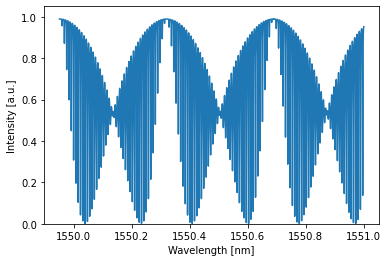

In [14]:
#Frequency Domain Response
wavelengths = 1e-9*np.linspace(1549.95,1551,10000)
freq_env = pt.Environment(wl=wavelengths, freqdomain=True)
wg_phase_=0
tr_=0.5
wg_delay_=1.02e-9
wl0_=1.55e-6
Bits=N
mzi_l1 = 1e-3
mzi_l2 = 13.12e-2  #ACTUAL FEEDBACK
mzi_fb = 3.88e-3   #MZI ARM
loss=20

ring_res_freqtest = dc_reservoir_freq(wg_delay=wg_delay_, wg_phase=wg_phase_, 
                            ng=ng, tr=tr_, neff=neff, mzi_l1=mzi_l1,
                            mzi_l2 = mzi_l2, mzi_fb=mzi_fb, loss=loss)


with freq_env:
    detected_freq = ring_res_freqtest(source=1)
ring_res_freqtest.plot(detected_freq)
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1
#plt.xlim(1549.5e3, 1550.7e-3)
plt.ylim(0, 1.05)
plt.show()
    

In [15]:
#Export to be plotted in MATLAB

detected_freq_np = detected_freq.numpy().reshape([10000,1])
det_data = pd.DataFrame(detected_freq_np)
det_data.to_csv('det_freq.csv')

## Training for Narma10 Task

tensor([0.8303, 0.1261, 0.9075, 0.8199, 0.9201, 0.1166, 0.1644, 0.7379, 0.0333,
        0.9942, 0.6064, 0.5646, 0.0724, 0.6593, 0.7150, 0.5793, 0.9809, 0.6502,
        0.0566, 0.9201, 0.6698, 0.2615, 0.0407, 0.7850, 0.9752, 0.0903, 0.5273,
        0.6794, 0.2639, 0.3906, 0.1661, 0.2636, 0.0442, 0.4884, 0.7965, 0.7432,
        0.9697, 0.0609, 0.4385, 0.9868, 0.5819, 0.3590, 0.0497, 0.7327, 0.8796,
        0.9009, 0.9186, 0.5979, 0.8564, 0.3741])
0.1219634064407828


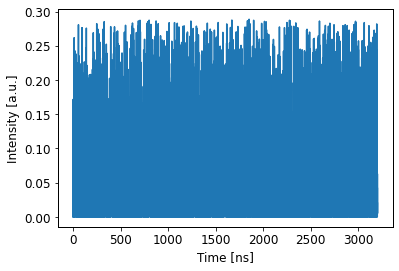

nmse: 0.6310600704946847
learning rate:[[  4445.514     1591.23      2902.3093   -2975.5583     813.5412
    4005.2778   -9395.363   -10838.997    -4592.835    -8273.054
   -2381.732    -8712.463    29838.947    -4598.1543   10675.041
  -11722.276      921.2373     521.89795   9935.197   -11494.343
    5286.8047    -200.156     6643.8657   15331.451    -4671.779
    1531.1614   11518.836     1682.9314   10424.198     6934.9404
   -4631.085     4344.137     3714.8958    3977.7305    2568.3376
   -5576.816    -6689.883      -52.84912   2779.5503    5927.9126
    2418.908    -1397.8245    2539.2493     831.5421    1506.7681
    3568.019    -4048.2966   -4877.0483     301.42188   3121.424  ]]
intercept:[0.27530923]


C:\Users\mohab\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


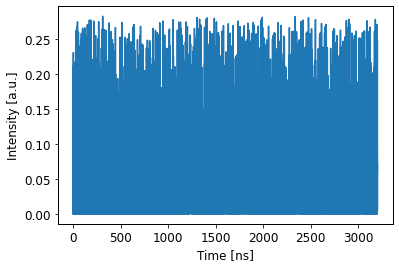

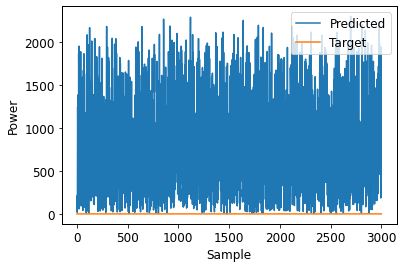

 nmse: 74730865.98423204


In [22]:
'''----- Training -----'''
torch.manual_seed(5)                      #pytorch seed
wg_phase_=0
tr_=0.5
fb_att_=0
wg_delay_=1.02e-9
wl0_=1.551e-6
wl0_va = 1.550e-6 #1.550161401e-6
Bits=N
mask_vector = torch.rand(Nodes)       #Input mask
print(mask_vector)
mzi_l1 = 1e-3 
mzi_l2 = 13.12e-3  #ACTUAL FEEDBACK
mzi_fb = 3.88e-3   #MZI ARM
loss = 20

ring_res_test = dc_reservoir(attenuation=fb_att_, wg_delay=wg_delay_, wg_phase=wg_phase_, 
                            ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes, mzi_l1=mzi_l1,
                            mzi_l2 = mzi_l2, mzi_fb=mzi_fb, loss=loss)

with pt.Environment(t=t, wl0=wl0_, num_wl=1):
    detected = ring_res_test(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    ring_res_test.plot(detected)
    plt.show()
        
#Data preparation -- Removing the first 200 bits
detected_np = detected.numpy()
detected_np = detected_np.reshape(Bits,Nodes)
target_now = narma10_jaeger(trbits).numpy().reshape(Bits,1)
detected_np_cut = detected_np[200:,:]
target_now_cut = target_now[200:]
        
#Regression and Prediction
regr = linear_model.LinearRegression()
x = regr.fit(detected_np_cut,target_now_cut)
y = regr.predict(detected_np_cut)
        
#Error Calculation
nmse = 1 - regr.score(detected_np_cut,target_now_cut)
mse = mse_new(target_now_cut,y,Bits)

print(f'nmse: {nmse}')            
print(f'learning rate:{regr.coef_}')
print(f'intercept:{regr.intercept_}')

'''----- Validation Test -----'''
with pt.Environment(t=t, wl0=wl0_va, num_wl=1):
    detected_va = ring_res_test(source=vastream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    ring_res_test.plot(detected_va)
    plt.show()

#Data preparation -- Removing the first 200 bits
detected_va_np = detected_va.numpy()
detected_va_np = detected_va_np.reshape(Bits,Nodes)
target_va_now = narma10_jaeger(vabits).numpy().reshape(Bits,1)
detected_va_np_cut = detected_va_np[200:,:]
target_va_now_cut = target_va_now[200:]

#Prediction
y_va = regr.predict(detected_va_np_cut)

#Error Calculation
nmse_va = 1 - regr.score(detected_va_np_cut,target_va_now_cut)
mse_va = mse_new(target_va_now_cut,y_va,Bits)

#Plots
plt.plot(y_va,label='Predicted')
plt.plot(target_va_now_cut,label='Target')
plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.ylabel('Power')
plt.show()

print(f' nmse: {nmse_va}')  

#ASYMMETRIC Length ARM2: 0.0038834064407827773

## Validating at delta fm wavelengths

0.0038834064407827773


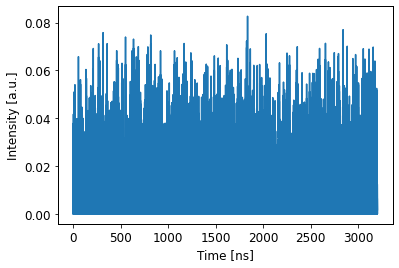

nmse: 0.12017838999380936
 wavelength: 1.55e-06, nmse: 0.12586706056241215
 wavelength: 1.5500000009999999e-06, nmse: 0.1260940326734452
 wavelength: 1.550000002e-06, nmse: 0.12685678827794256
 wavelength: 1.5500000029999999e-06, nmse: 0.1281341373763003
 wavelength: 1.550000004e-06, nmse: 0.12991211345714893
 wavelength: 1.550000005e-06, nmse: 0.132193488143999
 wavelength: 1.550000006e-06, nmse: 0.13499502555840104
 wavelength: 1.550000007e-06, nmse: 0.13833639425199318
 wavelength: 1.550000008e-06, nmse: 0.14222271803069964
 wavelength: 1.550000009e-06, nmse: 0.14664162858181784
 wavelength: 1.55000001e-06, nmse: 0.1515443943713236
 wavelength: 1.550000011e-06, nmse: 0.1568437211391588
 wavelength: 1.550000012e-06, nmse: 0.16244087604910373
 wavelength: 1.550000013e-06, nmse: 0.16828001193903896
 wavelength: 1.550000014e-06, nmse: 0.17436846517211757
 wavelength: 1.550000015e-06, nmse: 0.18075652861570735
 wavelength: 1.550000016e-06, nmse: 0.18749643817517625
 wavelength: 1.5500000

In [140]:
'''----- Training -----'''
torch.manual_seed(5)                      #pytorch seed
wg_phase_=0
tr_=0.5
fb_att_=0
wg_delay_=1.02e-9
wl0_=1.55e-6
Bits=N
mask_vector = 0.5*torch.rand(Nodes)       #Input mask
mzi_l1 = 2e-3
mzi_l2 = 13.12e-2

ring_res_test = dc_reservoir(attenuation=fb_att_, wg_delay=wg_delay_, wg_phase=wg_phase_, 
                            ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes, mzi_l1=mzi_l1,
                            mzi_l2 = mzi_l2)

with pt.Environment(t=t, wl0=wl0_, num_wl=1):
    detected = ring_res_test(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    ring_res_test.plot(detected)
    plt.show()
        
#Data preparation -- Removing the first 200 bits
detected_np = detected.numpy()
detected_np = detected_np.reshape(Bits,Nodes)
target_now = narma10_jaeger(trbits).numpy().reshape(Bits,1)
detected_np_cut = detected_np[200:,:]
target_now_cut = target_now[200:]
        
#Regression and Prediction
regr = linear_model.LinearRegression()
x = regr.fit(detected_np_cut,target_now_cut)
y = regr.predict(detected_np_cut)
        
#Error Calculation
nmse = 1 - regr.score(detected_np_cut,target_now_cut)
mse = mse_new(target_now_cut,y,Bits)

print(f'nmse: {nmse}')            


'''----- Validation Test -----'''
for i in range(100):
    wl0_va = 1.550e-6 + 1e-15*i
    with pt.Environment(t=t, wl0=wl0_va, num_wl=1):
        detected_va = ring_res_test(source=vastream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
        #ring_res_test.plot(detected_va)
        #plt.show()

    #Data preparation -- Removing the first 200 bits
    detected_va_np = detected_va.numpy()
    detected_va_np = detected_va_np.reshape(Bits,Nodes)
    target_va_now = narma10_jaeger(vabits).numpy().reshape(Bits,1)
    detected_va_np_cut = detected_va_np[200:,:]
    target_va_now_cut = target_va_now[200:]

    #Prediction
    y_va = regr.predict(detected_va_np_cut)

    #Error Calculation
    nmse_va = 1 - regr.score(detected_va_np_cut,target_va_now_cut)
    mse_va = mse_new(target_va_now_cut,y_va,Bits)

#Plots
#plt.plot(y_va,label='Predicted')
#plt.plot(target_va_now_cut,label='Target')
#plt.legend(loc='upper right')
#plt.xlabel('Sample')
#plt.ylabel('Power')
#plt.show()

    print(f' wavelength: {wl0_va}, nmse: {nmse_va}')  

#ASYMMETRIC Length ARM2: 0.0038834064407827773

## Validating at delta pm wavelengths

0.0038834064407827773


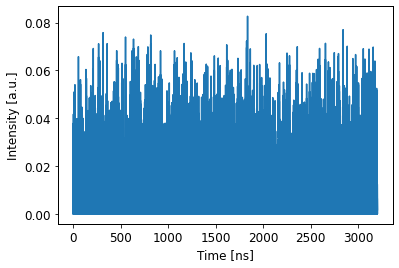

nmse: 0.12017838999380936
 wavelength: 1.559e-06, nmse: 28.908610238525128
 wavelength: 1.55900001e-06, nmse: 27.676259977950888
 wavelength: 1.55900002e-06, nmse: 26.82980869462644
 wavelength: 1.55900003e-06, nmse: 26.346110953841496
 wavelength: 1.55900004e-06, nmse: 26.09224263687163
 wavelength: 1.55900005e-06, nmse: 25.894744181344848
 wavelength: 1.55900006e-06, nmse: 25.828049279395994
 wavelength: 1.55900007e-06, nmse: 25.86433562730095
 wavelength: 1.55900008e-06, nmse: 25.92710982508654
 wavelength: 1.55900009e-06, nmse: 26.124860647612614
 wavelength: 1.5590001e-06, nmse: 26.404416298763962
 wavelength: 1.55900011e-06, nmse: 26.702588581762345
 wavelength: 1.55900012e-06, nmse: 26.960484403820036
 wavelength: 1.55900013e-06, nmse: 27.199344888999033
 wavelength: 1.5590001400000001e-06, nmse: 27.397881367354895
 wavelength: 1.55900015e-06, nmse: 27.521145902533863


KeyboardInterrupt: 

In [149]:
'''----- Training -----'''
torch.manual_seed(5)                      #pytorch seed
wg_phase_=0
tr_=0.5
fb_att_=0
wg_delay_=1.02e-9
wl0_=1.55e-6
Bits=N
mask_vector = 0.5*torch.rand(Nodes)       #Input mask
mzi_l1 = 2e-3
mzi_l2 = 13.12e-2

ring_res_test = dc_reservoir(attenuation=fb_att_, wg_delay=wg_delay_, wg_phase=wg_phase_, 
                            ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes, mzi_l1=mzi_l1,
                            mzi_l2 = mzi_l2)

with pt.Environment(t=t, wl0=wl0_, num_wl=1):
    detected = ring_res_test(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    ring_res_test.plot(detected)
    plt.show()
        
#Data preparation -- Removing the first 200 bits
detected_np = detected.numpy()
detected_np = detected_np.reshape(Bits,Nodes)
target_now = narma10_jaeger(trbits).numpy().reshape(Bits,1)
detected_np_cut = detected_np[200:,:]
target_now_cut = target_now[200:]
        
#Regression and Prediction
regr = linear_model.LinearRegression()
x = regr.fit(detected_np_cut,target_now_cut)
y = regr.predict(detected_np_cut)
        
#Error Calculation
nmse = 1 - regr.score(detected_np_cut,target_now_cut)
mse = mse_new(target_now_cut,y,Bits)

print(f'nmse: {nmse}')            


'''----- Validation Test -----'''
for i in range(100):
    wl0_va = 1.559e-6 + 1e-14*i
    with pt.Environment(t=t, wl0=wl0_va, num_wl=1):
        detected_va = ring_res_test(source=vastream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
        #ring_res_test.plot(detected_va)
        #plt.show()

    #Data preparation -- Removing the first 200 bits
    detected_va_np = detected_va.numpy()
    detected_va_np = detected_va_np.reshape(Bits,Nodes)
    target_va_now = narma10_jaeger(vabits).numpy().reshape(Bits,1)
    detected_va_np_cut = detected_va_np[200:,:]
    target_va_now_cut = target_va_now[200:]

    #Prediction
    y_va = regr.predict(detected_va_np_cut)

    #Error Calculation
    nmse_va = 1 - regr.score(detected_va_np_cut,target_va_now_cut)
    mse_va = mse_new(target_va_now_cut,y_va,Bits)

#Plots
#plt.plot(y_va,label='Predicted')
#plt.plot(target_va_now_cut,label='Target')
#plt.legend(loc='upper right')
#plt.xlabel('Sample')
#plt.ylabel('Power')
#plt.show()

    print(f' wavelength: {wl0_va}, nmse: {nmse_va}')  

#ASYMMETRIC Length ARM2: 0.0038834064407827773

## Delay Line Training

In [ ]:
'''----- Training -----'''
torch.manual_seed(3)                      #pytorch seed
wg_phase_=0
tr_=0.5
fb_att_=0
wg_delay_=1.02e-9
wl0_=1.55e-6
Bits=N
mask_vector = 0.5*torch.rand(Nodes)       #Input mask

delay_line_test = delay_line(wg_delay = wg_delay_, mask_vector = mask_vector, nodes = Nodes, ng = ng, neff = neff)

with pt.Environment(t=t, wl0=wl0_, num_wl=1):
    detected = delay_line_test(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    delay_line_test.plot(detected)
    plt.show()
        
#Data preparation -- Removing the first 200 bits
detected_np = detected.numpy()
detected_np = detected_np.reshape(Bits,Nodes)
target_now = narma10_jaeger(trbits).numpy().reshape(Bits,1)
detected_np_cut = detected_np[200:,:]
target_now_cut = target_now[200:]
        
#Regression and Prediction
regr = linear_model.LinearRegression()
x = regr.fit(detected_np_cut,target_now_cut)
y = regr.predict(detected_np_cut)
        
#Error Calculation
nmse = 1 - regr.score(detected_np_cut,target_now_cut)
mse = mse_new(target_now_cut,y,Bits)

## Wavelength Sweep 

In [13]:
Bits = N
wg_phase_=0    

for i in range(10):
    wl0_ = 1.5e-6 + 0.01e-6*i
    
    for j in range(5):
        wg_delay_=1.0e-9 + 0.02e-9*j


        dc_res = dc_reservoir(las_pow=las_pow, attenuation=fb_att_, wg_delay=wg_delay_, wg_phase=wg_phase_, 
                          ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes)

        with pt.Environment(t=t, wl0=wl0_, num_wl=1):
            detected = dc_res(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
        #ring_res.plot(detected)
        #plt.show()
    
        #Data preparation -- Removing the first 200 bits
        detected_np = detected.numpy()
        detected_np = detected_np.reshape(Bits,Nodes)
        target_now = narma10_jaeger(trbits).numpy().reshape(Bits,1)
        detected_np_cut = detected_np[200:,:]
        target_now_cut = target_now[200:]
        
        #Regression and Prediction
        regr = linear_model.LinearRegression()
        x = regr.fit(detected_np_cut,target_now_cut)
        y = regr.predict(detected_np_cut)
        
        #Error Calculation
        nmse = 1 - regr.score(detected_np_cut,target_now_cut)
        mse = mse_new(target_now_cut,y,Bits)
            
        print(f'wavelength: {wl0_}, delay: {wg_delay_} nmse: {nmse}')     

wavelength: 1.5e-06, delay: 1e-09 nmse: 0.6824404744937704
wavelength: 1.5e-06, delay: 1.02e-09 nmse: 0.6822035111415644
wavelength: 1.5e-06, delay: 1.0400000000000001e-09 nmse: 0.6828496621215904
wavelength: 1.5e-06, delay: 1.06e-09 nmse: 0.6832462610213947
wavelength: 1.5e-06, delay: 1.08e-09 nmse: 0.682117518879734
wavelength: 1.51e-06, delay: 1e-09 nmse: 0.6829398903999083
wavelength: 1.51e-06, delay: 1.02e-09 nmse: 0.6823133708229484
wavelength: 1.51e-06, delay: 1.0400000000000001e-09 nmse: 0.6830790555027666
wavelength: 1.51e-06, delay: 1.06e-09 nmse: 0.6814169759151281
wavelength: 1.51e-06, delay: 1.08e-09 nmse: 0.6824369177636992
wavelength: 1.52e-06, delay: 1e-09 nmse: 0.6828242905843361
wavelength: 1.52e-06, delay: 1.02e-09 nmse: 0.682802648678314
wavelength: 1.52e-06, delay: 1.0400000000000001e-09 nmse: 0.6827940313705649
wavelength: 1.52e-06, delay: 1.06e-09 nmse: 0.682720749815748
wavelength: 1.52e-06, delay: 1.08e-09 nmse: 0.6820810241267731
wavelength: 1.53e-06, delay: 1

KeyboardInterrupt: 

In [ ]:
Bits = N
wg_phase_=0    

for i in range(10):
    wl0_ = 1.55e-6 + 0.0001e-6*i
    
    for j in range(5):
        wg_delay_=1.0e-9 + 0.02e-9*j


        dc_res = dc_reservoir(las_pow=las_pow, attenuation=fb_att_, wg_delay=wg_delay_, wg_phase=wg_phase_, 
                          ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes)

        with pt.Environment(t=t, wl0=wl0_, num_wl=1):
            detected = dc_res(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
        #ring_res.plot(detected)
        #plt.show()
    
        #Data preparation -- Removing the first 200 bits
        detected_np = detected.numpy()
        detected_np = detected_np.reshape(Bits,Nodes)
        target_now = narma10_jaeger(trbits).numpy().reshape(Bits,1)
        detected_np_cut = detected_np[200:,:]
        target_now_cut = target_now[200:]
        
        #Regression and Prediction
        regr = linear_model.LinearRegression()
        x = regr.fit(detected_np_cut,target_now_cut)
        y = regr.predict(detected_np_cut)
        
        #Error Calculation
        nmse = 1 - regr.score(detected_np_cut,target_now_cut)
        mse = mse_new(target_now_cut,y,Bits)
            
        print(f'wavelength: {wl0_}, delay: {wg_delay_} nmse: {nmse}')     

## Mask Sweep

In [ ]:
Bits = N
wg_phase_=0    
wl0_ = 1.550004e-6

for i in range(10):
    #mask_ = 0.02*i + 0.1
    
    torch.manual_seed(i)                      #pytorch seed

    mask_vector = torch.rand(Nodes)       
    
    for j in range(5):
        wg_delay_=1.0e-9 + 0.02e-9*j


        dc_res = dc_reservoir(las_pow=las_pow, attenuation=fb_att_, wg_delay=wg_delay_, wg_phase=wg_phase_, 
                          ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes)

        with pt.Environment(t=t, wl0=wl0_, num_wl=1):
            detected = dc_res(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
        #ring_res.plot(detected)
        #plt.show()
    
        #Data preparation -- Removing the first 200 bits
        detected_np = detected.numpy()
        detected_np = detected_np.reshape(Bits,Nodes)
        target_now = narma10_jaeger(trbits).numpy().reshape(Bits,1)
        detected_np_cut = detected_np[200:,:]
        target_now_cut = target_now[200:]
        
        #Regression and Prediction
        regr = linear_model.LinearRegression()
        x = regr.fit(detected_np_cut,target_now_cut)
        y = regr.predict(detected_np_cut)
        
        #Error Calculation
        nmse = 1 - regr.score(detected_np_cut,target_now_cut)
        mse = mse_new(target_now_cut,y,Bits)
            
        print(f'mask seed: {i}, delay: {wg_delay_}, nmse: {nmse}')    

## Mask Sweep 2

In [ ]:
Bits = N
wg_phase_=0    
wg_delay_=1.06e-9
wl0_ = 1.550004e-6

for i in range(100):
    #mask_ = 0.02*i + 0.1
    
    torch.manual_seed(i)                      #pytorch seed

    mask_vector = torch.rand(Nodes)       
    

    dc_res = dc_reservoir(las_pow=las_pow, attenuation=fb_att_, wg_delay=wg_delay_, wg_phase=wg_phase_, 
                          ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes)

    with pt.Environment(t=t, wl0=wl0_, num_wl=1):
        detected = dc_res(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
        #ring_res.plot(detected)
        #plt.show()
    
    #Data preparation -- Removing the first 200 bits
    detected_np = detected.numpy()
    detected_np = detected_np.reshape(Bits,Nodes)
    target_now = narma10_jaeger(trbits).numpy().reshape(Bits,1)
    detected_np_cut = detected_np[200:,:]
    target_now_cut = target_now[200:]
        
    #Regression and Prediction
    regr = linear_model.LinearRegression()
    x = regr.fit(detected_np_cut,target_now_cut)
    y = regr.predict(detected_np_cut)
        
    #Error Calculation
    nmse = 1 - regr.score(detected_np_cut,target_now_cut)
    mse = mse_new(target_now_cut,y,Bits)
            
    print(f'mask seed: {i}, nmse: {nmse}')  

In [ ]:
Bits = N
wg_phase_=0    

wg_delay_=1.0e-9
wl0_=1.55e-6
mask_vector = 0.2*torch.rand(Nodes)       #Input mask

for i in range(10):
    wl0 = 1.5e-6 + 0.01e-6*i


    dc_res = dc_reservoir(las_pow=las_pow, attenuation=fb_att_, wg_delay=wg_delay_, wg_phase=wg_phase_, 
                          ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes)

    with pt.Environment(t=t, wl0=wl0, num_wl=1):
            detected = dc_res(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
        #ring_res.plot(detected)
        #plt.show()
    
    #Data preparation -- Removing the first 200 bits
    detected_np = detected.numpy()
    detected_np = detected_np.reshape(Bits,Nodes)
    target_now = narma10_jaeger(trbits).numpy().reshape(Bits,1)
    detected_np_cut = detected_np[200:,:]
    target_now_cut = target_now[200:]
        
    #Regression and Prediction
    regr = linear_model.LinearRegression()
    x = regr.fit(detected_np_cut,target_now_cut)
    y = regr.predict(detected_np_cut)
        
    #Error Calculation
    nmse = 1 - regr.score(detected_np_cut,target_now_cut)
    mse = mse_new(target_now_cut,y,Bits)
            
    print(f'wavelength: {wl0}, nmse: {nmse}')     

In [169]:
pt.DirectionalCoupler?

In [74]:
length=299792458*wg_delay_/ng
print(length-3.88e-3)
fsr = 1550e-9**2/(ng*length)
fsr2 = 1550e-9**2/(ng*5.88e-3)
print(f'fsr of long loop: {fsr}, fsr of shor loop: {fsr2}')

0.1312034064407828
fsr of long loop: 7.856742536407454e-12, fsr of shor loop: 1.804958410452576e-10
